# Условие задачи

Есть данные с металлургического комбината по режиму работы нагревающих электродов, добавлению различных компонентов в сплав и замерам температуры. 

Необходимо построить модель, которая предсказывала бы температуру сплава. Средняя абсолютная ошибка должна быть не более 6.

## План исследования
1. Исследование данных
2. План работы
3. Подготовка данных
4. Обучение и тестирование моделей  
Общий вывод

# 1. Исследование данных <a id='section1'></a>

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

###  data_arc

Откроем файл data_arc

In [2]:
data_arc = pd.read_csv('datasets/final_steel/data_arc.csv')
data_arc.name = 'data_arc'

Для удобства напишем функции дающие общую сводку по данным

In [3]:
def sub_col(column):
    if column.name != 'key':
        print('=========================')
        print(column.name)
        print('=========================')
        print(column.describe())
        if is_numeric_dtype(column) == True:
            print(column.hist(bins=50))
            plt.show()
            print(column.plot(grid=True, figsize=(12, 5)))
            plt.show()

In [4]:
def sub_df(df):
    print('=========================')
    print('=========================')
    print(df.name)
    print('=========================')
    print('=========================')
    df.info()
    print('=========================')
    print(df.head())
    print('=========================')
    for column in df.columns.tolist():
        sub_col(df[column])

Применим функцию для получения сводки

data_arc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0         

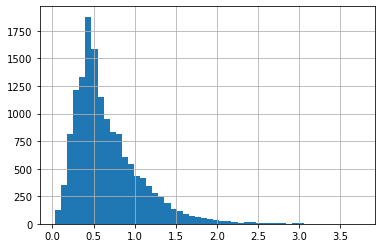

AxesSubplot(0.125,0.125;0.775x0.755)


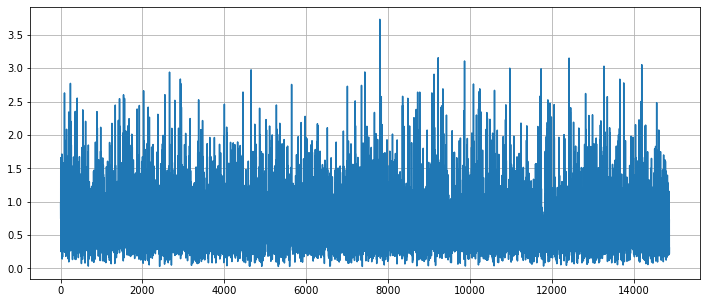

Реактивная мощность
count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


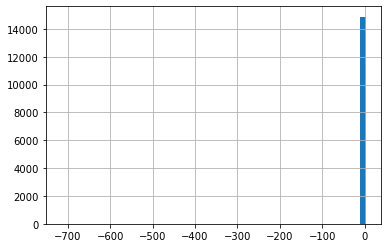

AxesSubplot(0.125,0.125;0.775x0.755)


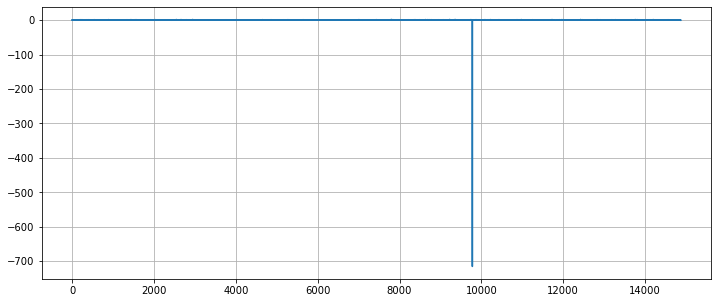

In [5]:
sub_df(data_arc)

Пропусков не обнаружено. 

Данные по времени имеют неверный тип, а также присутствует дубликат во времени начала нагрева дугой. Судя по всему замеры времени должны быть последовательными. Необходимо проверить не нарушена ли где последовательность. 

Есть данные по мощности и времени нагрева, но нам важнее работа. Можно создать отдельный столбец с рассчитанной работой.

В реактивной мощности обнаружен выброс. Необходимо удалить данные по всей партии.

### data_bulk

Загрузим данные и получим сводку

data_bulk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN  

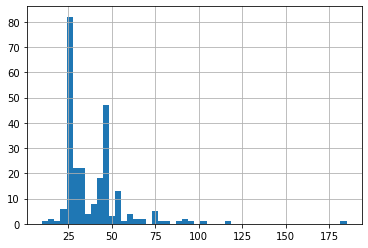

AxesSubplot(0.125,0.125;0.775x0.755)


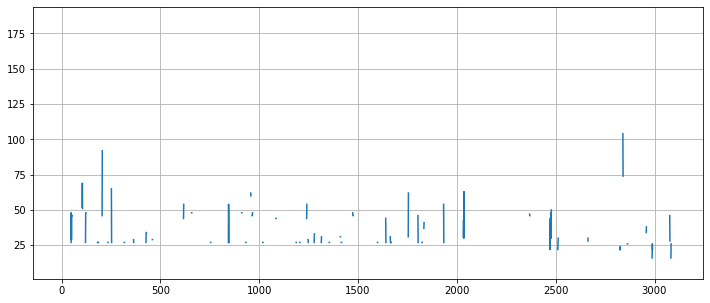

Bulk 2
count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


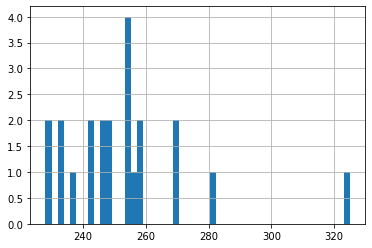

AxesSubplot(0.125,0.125;0.775x0.755)


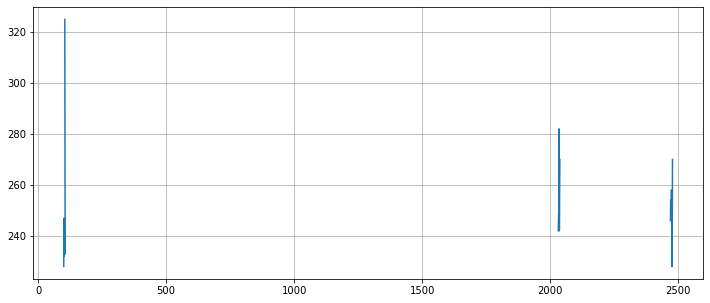

Bulk 3
count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


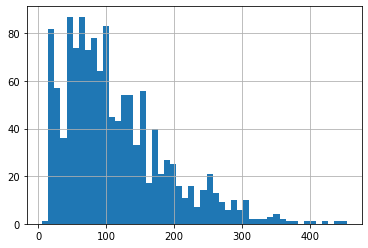

AxesSubplot(0.125,0.125;0.775x0.755)


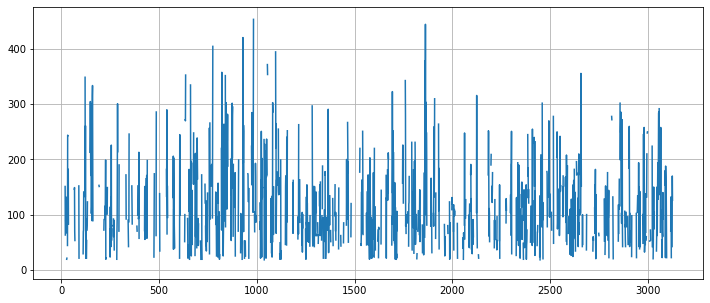

Bulk 4
count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


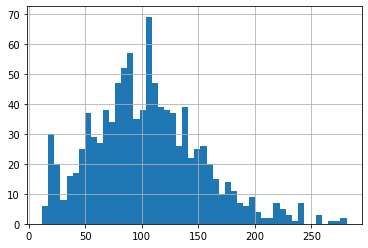

AxesSubplot(0.125,0.125;0.775x0.755)


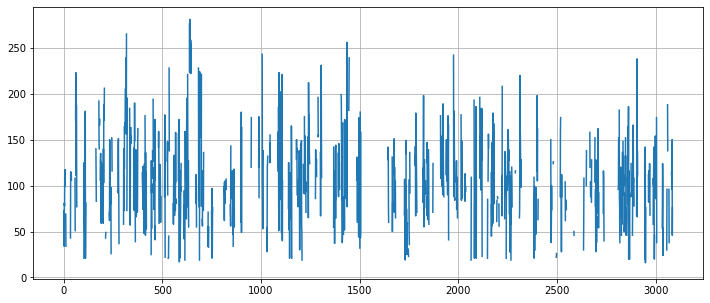

Bulk 5
count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


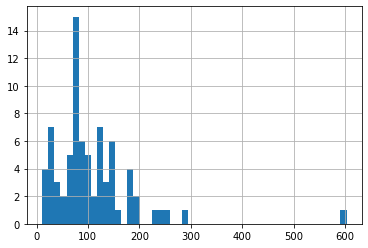

AxesSubplot(0.125,0.125;0.775x0.755)


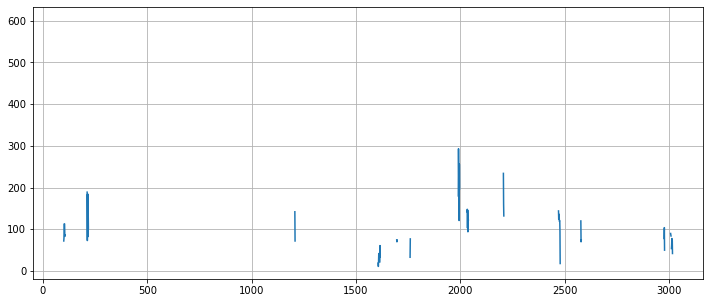

Bulk 6
count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


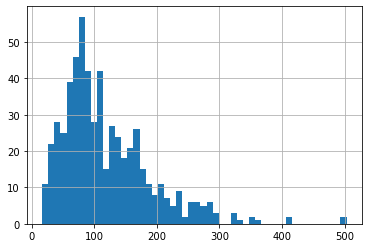

AxesSubplot(0.125,0.125;0.775x0.755)


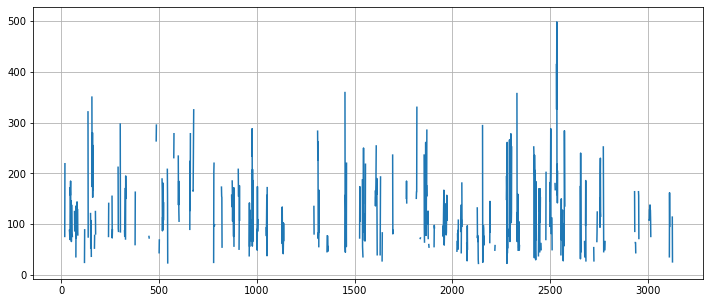

Bulk 7
count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


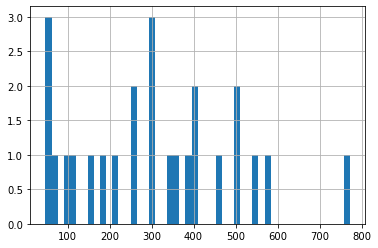

AxesSubplot(0.125,0.125;0.775x0.755)


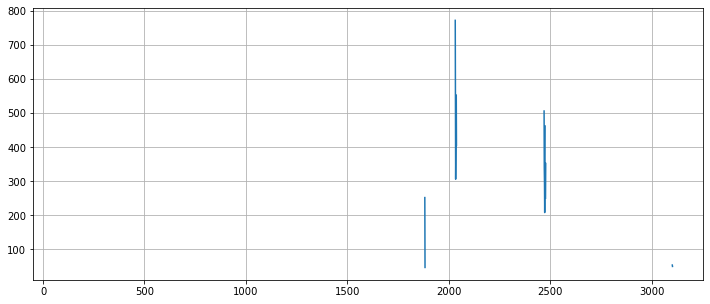

Bulk 8
count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


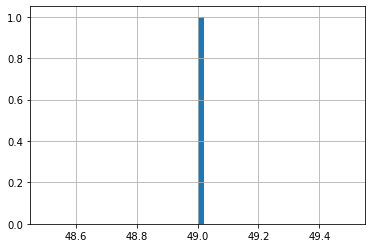

AxesSubplot(0.125,0.125;0.775x0.755)


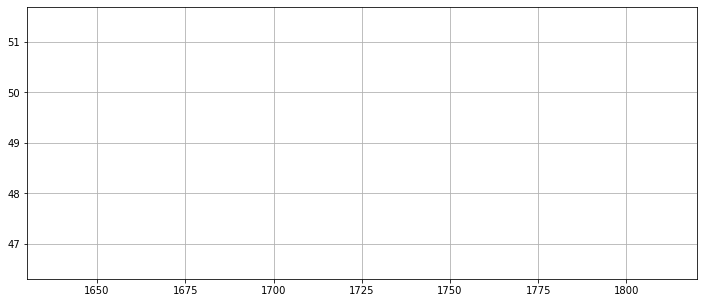

Bulk 9
count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


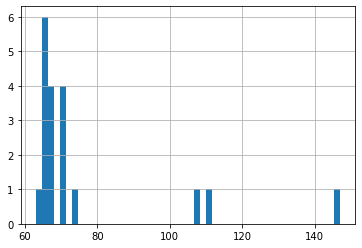

AxesSubplot(0.125,0.125;0.775x0.755)


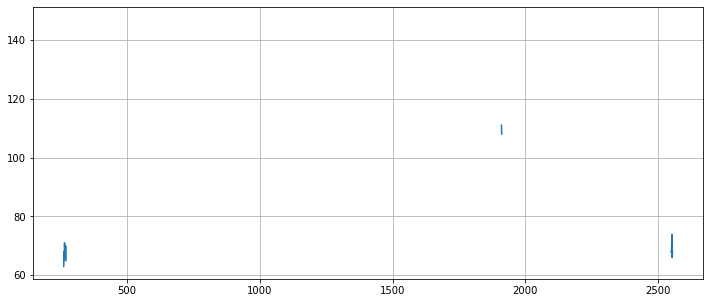

Bulk 10
count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


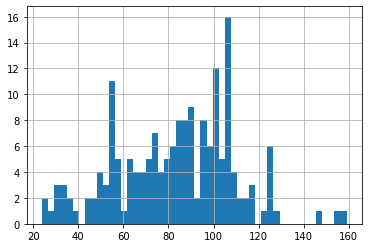

AxesSubplot(0.125,0.125;0.775x0.755)


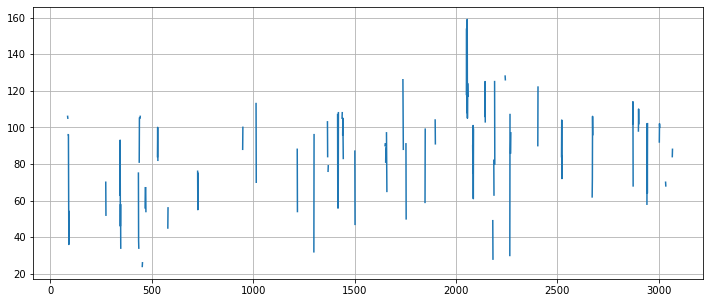

Bulk 11
count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


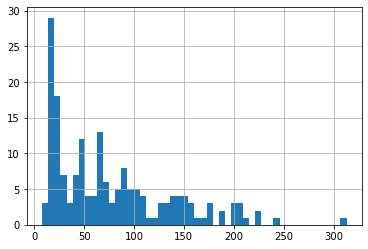

AxesSubplot(0.125,0.125;0.775x0.755)


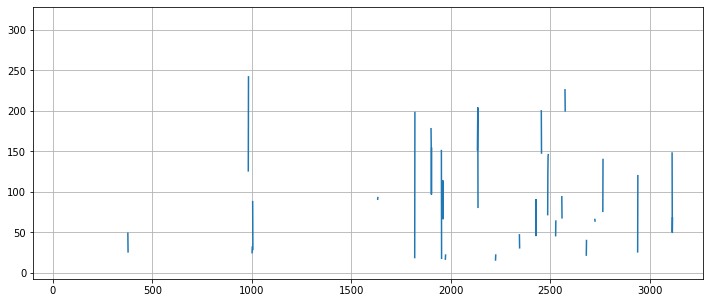

Bulk 12
count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


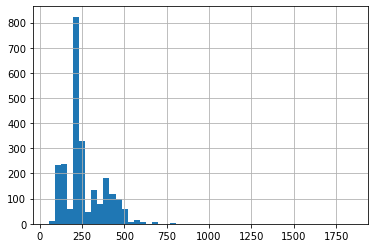

AxesSubplot(0.125,0.125;0.775x0.755)


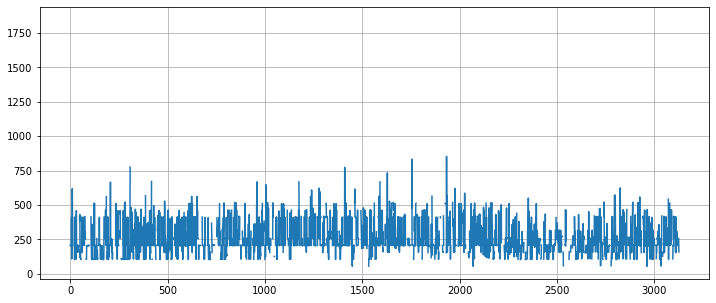

Bulk 13
count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


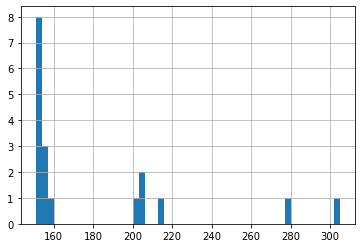

AxesSubplot(0.125,0.125;0.775x0.755)


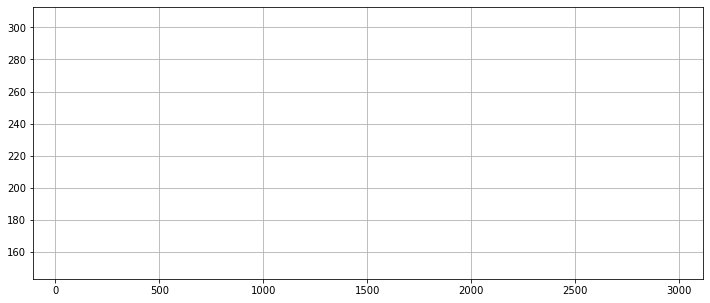

Bulk 14
count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


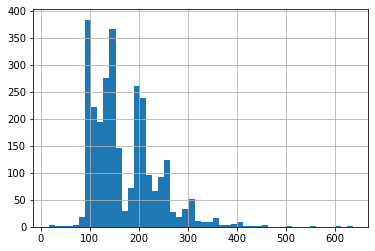

AxesSubplot(0.125,0.125;0.775x0.755)


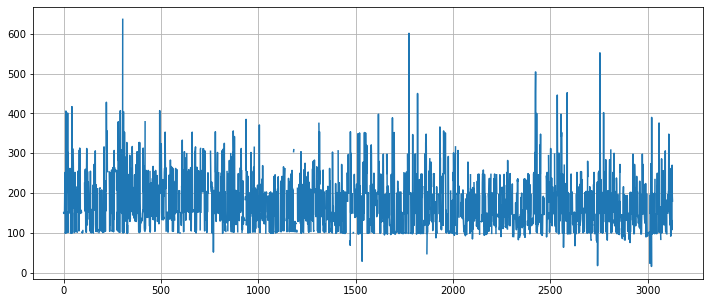

Bulk 15
count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


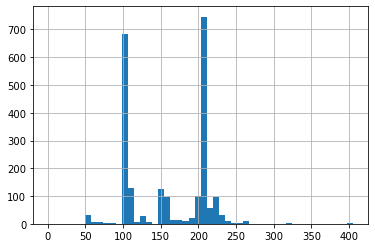

AxesSubplot(0.125,0.125;0.775x0.755)


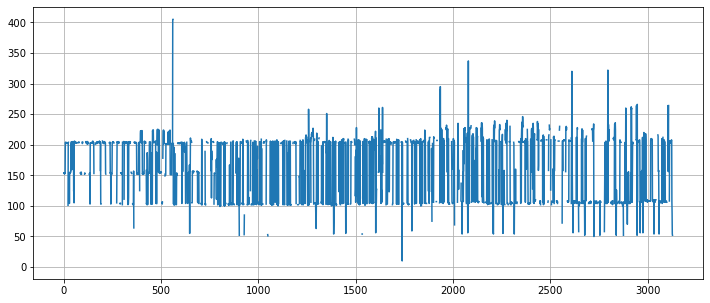

In [6]:
data_bulk = pd.read_csv('datasets/final_steel/data_bulk.csv')
data_bulk.name = 'data_bulk'

sub_df(data_bulk)

Аномалий не обнаружено, но есть пропуски. Судя по всему пропуски можно заполнить нулями.

### data_bulk_time

In [7]:
data_bulk_time = pd.read_csv('datasets/final_steel/data_bulk_time.csv')
data_bulk_time.name = 'data_bulk_time'

sub_df(data_bulk_time)

data_bulk_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
   key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   

Обнаружен неверный тип данных и пропуски. Но по требованию заказчика нельзя использовать промежуточные данные температуры. Поэтому таблица data_bulk_time для работы не понадобится.

### data_gas

data_gas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
   key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
Газ 1
count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


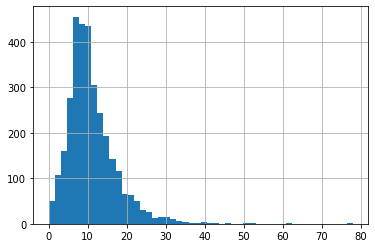

AxesSubplot(0.125,0.125;0.775x0.755)


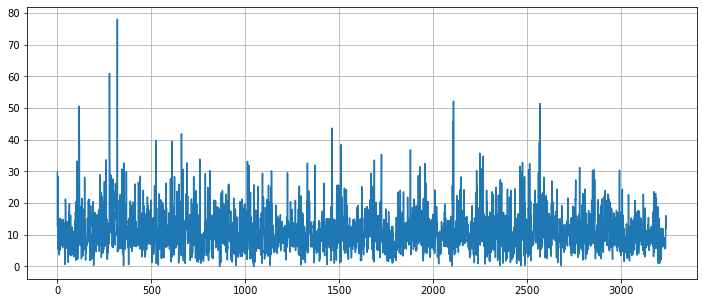

In [8]:
data_gas = pd.read_csv('datasets/final_steel/data_gas.csv')
data_gas.name = 'data_gas'

sub_df(data_gas)

Данные выглядят нормально. Аномалий не обнаружено.

### data_temp

data_temp
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
   key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0
Время замера
count                   15907
unique                  15907
top       2019-08-30 22:47:33
freq                        1
Name: Время замера, dtype: object
Температура
count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Na

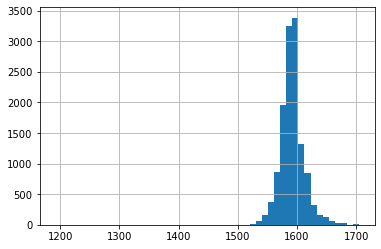

AxesSubplot(0.125,0.125;0.775x0.755)


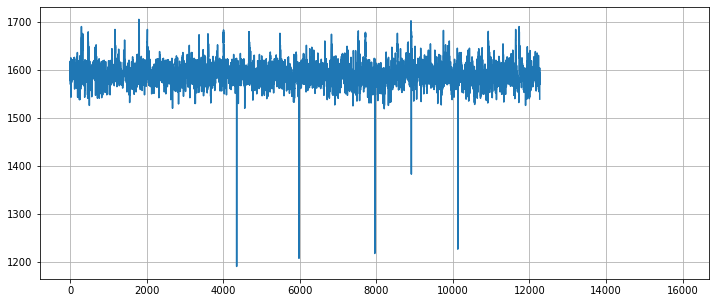

In [9]:
data_temp = pd.read_csv('datasets/final_steel/data_temp.csv')
data_temp.name = 'data_temp'

sub_df(data_temp)

Обнаружены пропуски в показаниях температуры. Такие строки нужно удалить. Данные по времени имеют не верный тип. Также были замечены явные выбросы. Необходимо их изучить.

### data_wire

data_wire
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
   key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN 

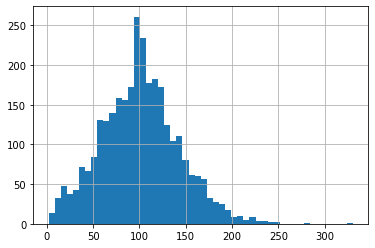

AxesSubplot(0.125,0.125;0.775x0.755)


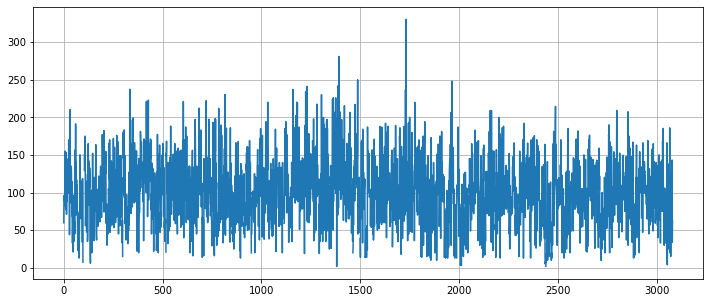

Wire 2
count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


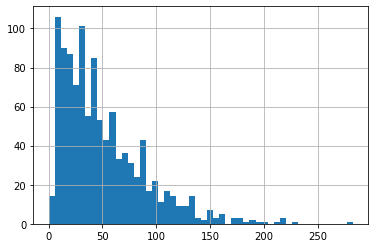

AxesSubplot(0.125,0.125;0.775x0.755)


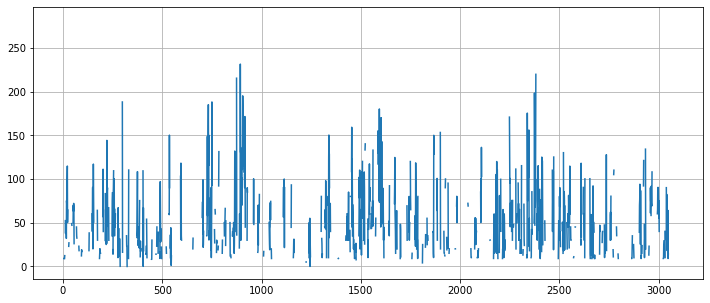

Wire 3
count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


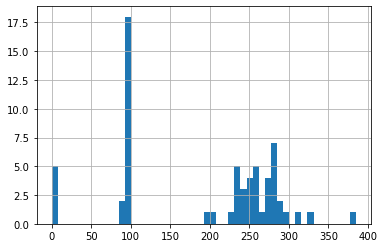

AxesSubplot(0.125,0.125;0.775x0.755)


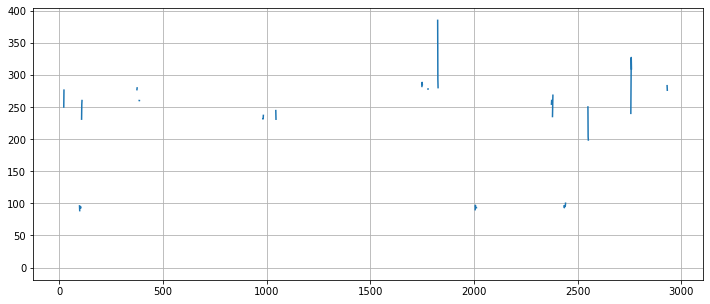

Wire 4
count     14.000000
mean      57.442842
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


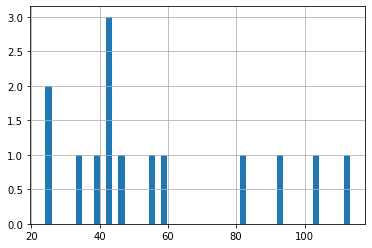

AxesSubplot(0.125,0.125;0.775x0.755)


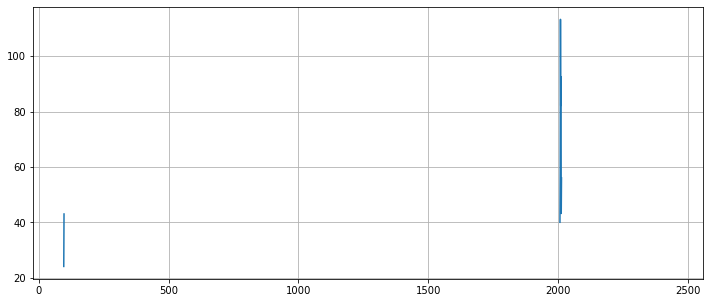

Wire 5
count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


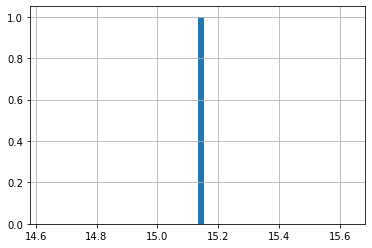

AxesSubplot(0.125,0.125;0.775x0.755)


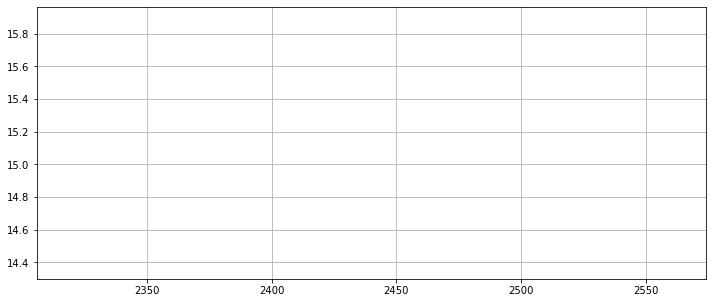

Wire 6
count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


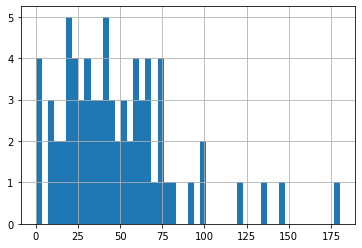

AxesSubplot(0.125,0.125;0.775x0.755)


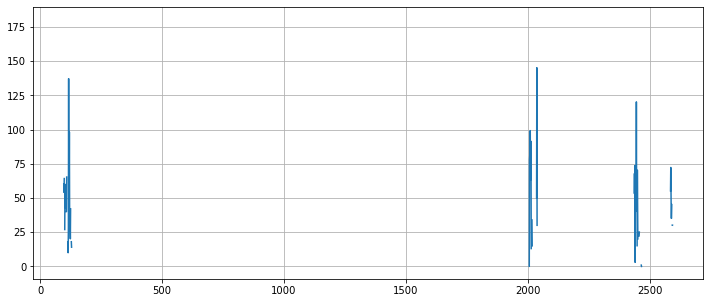

Wire 7
count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


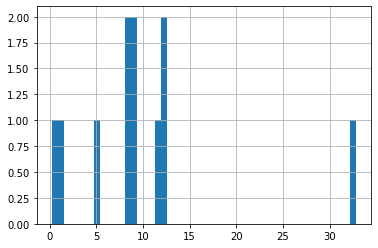

AxesSubplot(0.125,0.125;0.775x0.755)


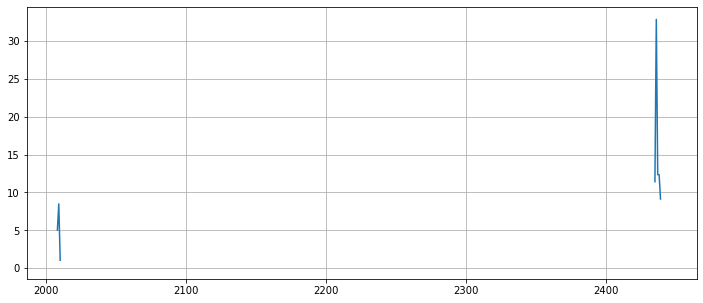

Wire 8
count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


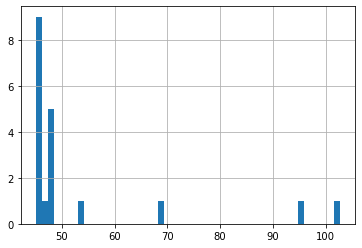

AxesSubplot(0.125,0.125;0.775x0.755)


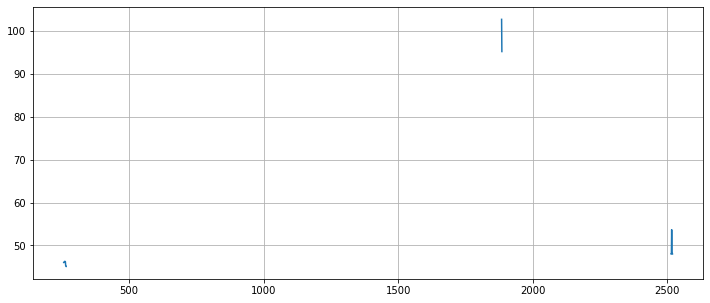

Wire 9
count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


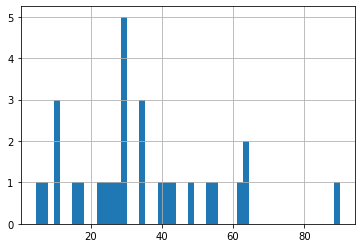

AxesSubplot(0.125,0.125;0.775x0.755)


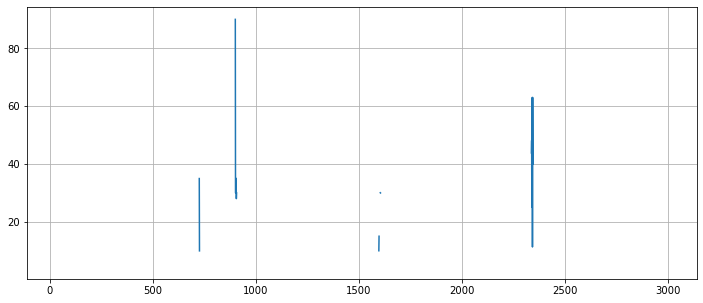

In [10]:
data_wire = pd.read_csv('datasets/final_steel/data_wire.csv')
data_wire.name = 'data_wire'

sub_df(data_wire)

Данные выглядят нормально, но необходимо заполнить пропуски нулями.

### data_wire_time

In [11]:
data_wire_time = pd.read_csv('datasets/final_steel/data_wire_time.csv')
data_wire_time.name = 'data_wire_time'

sub_df(data_wire_time)

data_wire_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
   key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    N

Эта таблица тоже не пригодится, т.к. содержит промежуточные данные.

### Вывод
Необходимо подробнее исследовать аномалии в данных data_arc и data_temp. Данные из таблиц data_bulk_time data_wire_time не потребуются по условию заказчика. Во всех остальных данных необходимо провести предобработку. 

# 2. План работы <a id='section2'></a>

#### 1. Подробное исследование и подготовка данных  
Необходимо проверить корректность данных по времени и обнаруженные аномалии. Также нужно заполнить пропуски и привести данные к верным типам. Планируется использовать следующие признаки:  

    1) Работа совершенная электродами на  всю партию  
    2) Общее время работы с партией  
    3) Подача сыпучих материалов  
    4) Продувка газом  
    5) Подача проволочных материалов  
    6) Температура в начале цикла  
    7) Температура в конце цикла (целевой признак)
    
    Все признаки соберем в одну таблицу и разделим на обучающие и тестовые данные.
#### 2. Обучение моделей
    Для решения задачи используем три модели: линейную регрессию, случайный лес и LightGBM. Для каждой подберем оптимальные гиперпараметры и обучим модели на обучающих данных. 
#### 3. Тестирование моделей
    Посчитаем MAE каждой модели на тестовых данных и соберем полученные результаты в таблицу для сравнения.

# 3. Подготовка данных <a id='section3'></a>

### data_arc

Поменяем тип данных по времени

In [12]:
data_arc['Начало нагрева дугой']= pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой']= pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Удалим информацию по партии с обнаруженным выбросом

In [13]:
data_arc[data_arc['Реактивная мощность'] < 0].key

9780    2116
Name: key, dtype: int64

In [14]:
data_arc = data_arc.query('key != 2116')

Найдем дубликат во времени начала нагрева дугой и изучим данные по партиям

Сначала найдем продублированное время

In [15]:
data_arc['Начало нагрева дугой'].value_counts()

2019-06-10 22:02:03    2
2019-05-22 20:41:41    1
2019-06-22 17:31:28    1
2019-08-19 15:51:02    1
2019-08-25 06:13:36    1
                      ..
2019-05-18 20:21:43    1
2019-07-26 06:16:55    1
2019-06-18 22:47:12    1
2019-06-10 07:05:54    1
2019-06-11 07:23:13    1
Name: Начало нагрева дугой, Length: 14871, dtype: int64

Получим номера партий с дубликатом

In [16]:
data_arc[data_arc['Начало нагрева дугой'] == '2019-06-10 22:02:03'].key

4872    1051
4876    1052
Name: key, dtype: int64

Проверим данные по партиям

In [17]:
data_arc.query('key == 1051 or key == 1052')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
4866,1051,2019-06-10 21:10:52,2019-06-10 21:16:30,1.448011,1.045037
4867,1051,2019-06-10 21:17:31,2019-06-10 21:24:27,2.003559,1.248206
4868,1051,2019-06-10 21:25:37,2019-06-10 21:30:51,1.528554,0.892720
4869,1051,2019-06-10 21:32:03,2019-06-10 21:36:58,1.417861,0.818525
4870,1051,2019-06-10 21:53:30,2019-06-10 21:54:50,0.337850,0.198380
4871,1051,2019-06-10 21:55:47,2019-06-10 22:00:57,1.352988,0.823782
4872,1051,2019-06-10 22:02:03,2019-06-10 22:06:02,1.040376,0.635608
4873,1052,2019-06-10 21:46:15,2019-06-10 21:52:20,1.292979,1.094674
4874,1052,2019-06-10 21:53:58,2019-06-10 21:58:07,1.098052,0.737462
4875,1052,2019-06-10 21:59:46,2019-06-10 22:00:20,0.134783,0.092384


Время явно попало в первую партию по ошибке. Данные по партии 1051 необходимо удалить.

In [18]:
data_arc = data_arc.query('key != 1051')
data_arc['Начало нагрева дугой'].describe()

count                   14865
unique                  14865
top       2019-05-22 20:41:41
freq                        1
first     2019-05-03 11:02:14
last      2019-09-01 04:34:47
Name: Начало нагрева дугой, dtype: object

Дубликата нет. Но необходимо проверить, корректны ли остальные данные по времени. Для этого сравним все записи по времени со следующими. Предыдущие всегда должны быть меньше.

Обновим индексы, т.к. некоторые строки были удалены.

In [19]:
data_arc = data_arc.reset_index(drop=True)

Пометим последнии записи в партии

In [20]:
data_arc['is_last'] = 0

for i in range(len(data_arc)-1):
    if data_arc.key[i] == data_arc.key[i+1]:
        data_arc['is_last'][i] = 0
    else:
        data_arc['is_last'][i] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
data_arc['is_last'][len(data_arc) - 1] = 1 # последнюю строчку пометим вручную
data_arc.tail(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,is_last
14855,3240,2019-09-01 02:35:24,2019-09-01 02:37:25,0.411601,0.274390,0
14856,3240,2019-09-01 02:40:55,2019-09-01 02:43:28,0.521811,0.378517,0
14857,3240,2019-09-01 03:08:38,2019-09-01 03:11:08,0.518065,0.528780,0
14858,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.983723,0.884585,0
14859,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994,1
14860,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0
14861,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0
14862,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0
14863,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0
14864,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708,1


Создадим столбцы для следующих замеров времени, чтобы можно было сравнить с текущим.

In [22]:
data_arc = data_arc.reset_index(drop=True)
data_arc['Начало нагрева дугой 2'] = data_arc[1:]['Начало нагрева дугой'].reset_index(drop=True)
data_arc['Начало нагрева дугой 2'][len(data_arc) - 1] = data_arc['Начало нагрева дугой'][len(data_arc) - 1]

data_arc = data_arc.reset_index(drop=True)
data_arc['Конец нагрева дугой 2'] = data_arc[1:]['Конец нагрева дугой'].reset_index(drop=True)
data_arc['Конец нагрева дугой 2'][len(data_arc) - 1] = data_arc['Конец нагрева дугой'][len(data_arc) - 1]
data_arc

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,is_last,Начало нагрева дугой 2,Конец нагрева дугой 2
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0,2019-05-03 11:07:28,2019-05-03 11:10:33
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0,2019-05-03 11:11:44,2019-05-03 11:14:36
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0,2019-05-03 11:18:14,2019-05-03 11:24:19
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0,2019-05-03 11:26:09,2019-05-03 11:28:37
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,1,2019-05-03 11:34:14,2019-05-03 11:36:31
...,...,...,...,...,...,...,...,...
14860,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0,2019-09-01 04:05:04,2019-09-01 04:08:04
14861,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0,2019-09-01 04:16:41,2019-09-01 04:19:45
14862,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0,2019-09-01 04:31:51,2019-09-01 04:32:48
14863,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0,2019-09-01 04:34:47,2019-09-01 04:36:08


Найдем количество ошибок последовательности внутри и в конце партии

In [23]:
wrong_time = data_arc[data_arc['Конец нагрева дугой 2'] < data_arc['Конец нагрева дугой']].merge(
    data_arc[data_arc['Начало нагрева дугой 2'] < data_arc['Начало нагрева дугой']], how='outer')
print('Ошибки последовательности внутри партии', len(wrong_time.query('is_last == 0')))
print('Ошибки последовательности в конце партии', len(wrong_time.query('is_last == 1')))

Ошибки последовательности внутри партии 0
Ошибки последовательности в конце партии 104


Похоже больше нет нарушения последовательности времени внутри партии. Судя по всему 104 партии перепутаны местами. Но это не критично для работы.

#### Создадим столбец с рассчитанной работой 

In [24]:
data_arc['time'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).astype('timedelta64[s]')
data_arc['active_work'] = data_arc['time'] * data_arc['Активная мощность']

data_arc['time'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).astype('timedelta64[s]')
data_arc['reactive_work'] = data_arc['time'] * data_arc['Реактивная мощность']

data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,is_last,Начало нагрева дугой 2,Конец нагрева дугой 2,time,active_work,reactive_work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0,2019-05-03 11:07:28,2019-05-03 11:10:33,228.0,222.541395,156.655088
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0,2019-05-03 11:11:44,2019-05-03 11:14:36,185.0,149.037310,96.252771
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0,2019-05-03 11:18:14,2019-05-03 11:24:19,172.0,128.030509,85.794529
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0,2019-05-03 11:26:09,2019-05-03 11:28:37,365.0,605.667332,387.874330
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,1,2019-05-03 11:34:14,2019-05-03 11:36:31,148.0,102.527702,61.330791


Соберем информацию по активной и рекативной работе на партию

In [25]:
full_data = data_arc.drop(data_arc.columns[1:9], axis=1).groupby(by='key').sum()
full_data

,active_work,reactive_work
key,,
1,1207.804249,787.907510
2,733.816470,487.590677
3,443.583327,280.936835
4,670.663327,429.935932
5,997.496095,664.940090
...,...,...
3237,777.993447,559.334413
3238,432.849310,348.343323
3239,844.977151,557.964769


### data_temp

Переведем данные по времени в верный тип

In [26]:
data_temp['Время замера']= pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Удалим строки с пропусками в температуре

In [27]:
data_temp = data_temp.dropna()
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   Время замера  13006 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


Найдем партии с выбросами

In [28]:
wrong_keys = data_temp[data_temp['Температура'] < 1500].key
data_temp.query('key in @wrong_keys')

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0


Чаще всего низкие температуры встречаются в начале партии. Возможно это не ошибки. В таком случае в этих партиях должен быть значительно выше объем работы. Проверим это предположение.

Создадим список предыдущих партий

In [29]:
prev_wrong_keys = wrong_keys - 1

Сравним объемы работ в партиях с низкими температурами с предыдущими партиями

      active_work  reactive_work
key                             
866    184.894766     146.380732
1213   308.056868     232.470420
1618   420.028057     334.133233
1817  2601.434066    1910.599851
2051   313.825238     244.571028
2560  2591.575940    1818.058189
      active_work  reactive_work
key                             
867    670.938681     483.244566
1214   444.668790     313.695638
1619   106.070712      82.813433
1818  2615.874997    1906.056929
2052   405.639563     327.934596
2561   741.355365     540.045920


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CED3CC8>,
      dtype=object)

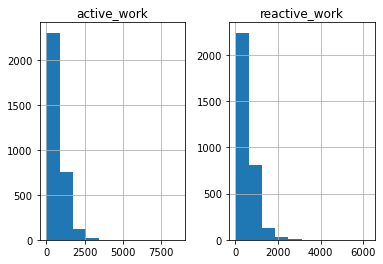

In [30]:
print(full_data.query('key in @prev_wrong_keys'))
print(full_data.query('key in @wrong_keys'))
full_data.hist()

Значительного повышения объема работы не замечено. Решено выбросы удалить.

In [31]:
data_temp = data_temp.query('key not in @wrong_keys')

Проверим последовательность времени внутри партий

In [32]:
data_temp = data_temp.reset_index(drop=True)

data_temp['is_last'] = 0

for i in range(len(data_temp)-1):
    if data_temp.key[i] == data_temp.key[i+1]:
        data_temp['is_last'][i] = 0
    else:
        data_temp['is_last'][i] = 1

data_temp['is_last'][len(data_temp) - 1] = 1
        
data_temp

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,key,Время замера,Температура,is_last
0,1,2019-05-03 11:16:18,1571.0,0
1,1,2019-05-03 11:25:53,1604.0,0
2,1,2019-05-03 11:29:11,1618.0,0
3,1,2019-05-03 11:30:01,1601.0,0
4,1,2019-05-03 11:30:39,1613.0,1
...,...,...,...,...
12956,3237,2019-08-31 22:44:04,1569.0,1
12957,3238,2019-08-31 23:30:31,1584.0,1
12958,3239,2019-09-01 01:31:47,1598.0,1
12959,3240,2019-09-01 02:39:01,1617.0,1


Замечены партии с всего одним замером температуры. Информацию по таким партиям необходимо будет удалить.

In [33]:
data_temp['Время замера 2'] = data_temp[1:]['Время замера'].reset_index(drop=True)
data_temp['Время замера 2'][len(data_temp) - 1] = data_temp['Время замера'][len(data_temp) - 1]

print('В конце партии', len(data_temp[(data_temp['Время замера 2'] < data_temp['Время замера']) & (data_temp['is_last'] == 1)]))
print('Внутри партии', len(data_temp[(data_temp['Время замера 2'] < data_temp['Время замера']) & (data_temp['is_last'] == 0)]))

В конце партии 86
Внутри партии 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Также есть партии, перепутанные местами. Внутри всех партий последовательность времени правильная.

Удалим партии с всего одним замером

In [34]:
wrong_keys = pd.DataFrame(data_temp['key'].value_counts())
wrong_keys = wrong_keys.query('key == 1').index
data_temp = data_temp.query('key not in @wrong_keys')
data_temp.key.value_counts()

44      16
46      16
1513    16
1689    15
2108    15
        ..
1416     2
1424     2
1590     2
1631     2
1712     2
Name: key, Length: 2470, dtype: int64

Удалим лишние столбцы

In [35]:
data_temp = data_temp.drop(data_temp.columns[3:5], axis=1)

Создадим 2 таблицы: с первым и последним измерением в партии

In [36]:
first = data_temp.drop_duplicates(subset=['key'])
last = data_temp.drop_duplicates(subset=['key'], keep='last')

In [37]:
first = first.set_index('key', drop=False)
first = first.drop(first.columns[0], axis=1)
first

,Время замера,Температура
key,,
1,2019-05-03 11:16:18,1571.0
2,2019-05-03 11:37:27,1581.0
3,2019-05-03 12:13:17,1596.0
4,2019-05-03 12:52:57,1601.0
5,2019-05-03 13:23:19,1576.0
...,...,...
2495,2019-08-06 00:35:45,1570.0
2496,2019-08-06 01:02:54,1554.0
2497,2019-08-06 01:41:53,1571.0


In [38]:
last = last.set_index('key', drop=False)
last = last.drop(last.columns[0], axis=1)
last

,Время замера,Температура
key,,
1,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:36:01,1602.0
...,...,...
2495,2019-08-06 00:54:42,1591.0
2496,2019-08-06 01:29:52,1591.0
2497,2019-08-06 01:53:50,1589.0


Добавим начальные и конечные температуры и значения времени в таблицу full_data

In [39]:
full_data['time_1'] = first['Время замера']
full_data['time_2'] = last['Время замера']
full_data['temp_1'] = first['Температура']
full_data['temp_2'] = last['Температура']
full_data

,active_work,reactive_work,time_1,time_2,temp_1,temp_2
key,,,,,,
1,1207.804249,787.907510,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,733.816470,487.590677,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
3,443.583327,280.936835,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
4,670.663327,429.935932,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
5,997.496095,664.940090,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...,...,...
3237,777.993447,559.334413,NaT,NaT,NaN,NaN
3238,432.849310,348.343323,NaT,NaT,NaN,NaN
3239,844.977151,557.964769,NaT,NaT,NaN,NaN


Посчитаем время между замерами в партии и удалим лишнии столбцы

In [40]:
full_data['time'] = (full_data['time_2'] - full_data['time_1']).astype('timedelta64[s]')
full_data = full_data.drop(full_data.columns[[2,3]], axis=1)
full_data

,active_work,reactive_work,temp_1,temp_2,time
key,,,,,
1,1207.804249,787.907510,1571.0,1613.0,861.0
2,733.816470,487.590677,1581.0,1602.0,1305.0
3,443.583327,280.936835,1596.0,1599.0,1300.0
4,670.663327,429.935932,1601.0,1625.0,388.0
5,997.496095,664.940090,1576.0,1602.0,762.0
...,...,...,...,...,...
3237,777.993447,559.334413,NaN,NaN,NaN
3238,432.849310,348.343323,NaN,NaN,NaN
3239,844.977151,557.964769,NaN,NaN,NaN


### data_bulk

Заполним пропуски нулями

In [41]:
data_bulk = data_bulk.fillna(0)

Добавим данные в таблицу full_data

In [42]:
data_bulk = data_bulk.set_index('key', drop=False)
data_bulk = data_bulk.drop(data_bulk.columns[0], axis=1)
full_data = pd.concat([full_data, data_bulk], axis = 1)

### data_gas

Добавим информацию по газу в общую таблицу

In [43]:
data_gas = data_gas.set_index('key', drop=False)
data_gas = data_gas.drop(data_gas.columns[0], axis=1)

In [44]:
full_data = pd.concat([full_data, data_gas], axis = 1)
full_data = full_data.rename(columns={'Газ 1': 'gas'})
full_data

,active_work,reactive_work,temp_1,temp_2,time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1207.804249,787.907510,1571.0,1613.0,861.0,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
2,733.816470,487.590677,1581.0,1602.0,1305.0,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
3,443.583327,280.936835,1596.0,1599.0,1300.0,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
4,670.663327,429.935932,1601.0,1625.0,388.0,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
5,997.496095,664.940090,1576.0,1602.0,762.0,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,777.993447,559.334413,NaN,NaN,NaN,0.0,0.0,170.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,5.543905
3238,432.849310,348.343323,NaN,NaN,NaN,0.0,0.0,126.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,6.745669
3239,844.977151,557.964769,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,16.023518


### data_wire

Заполним пропуски нулями

In [45]:
data_wire = data_wire.fillna(0)
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Добавим данные в общую таблицу

In [46]:
data_wire = data_wire.set_index('key', drop=False)
data_wire = data_wire.drop(data_wire.columns[0], axis=1)
full_data = pd.concat([full_data, data_wire], axis = 1)
full_data

,active_work,reactive_work,temp_1,temp_2,time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1207.804249,787.907510,1571.0,1613.0,861.0,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,733.816470,487.590677,1581.0,1602.0,1305.0,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,443.583327,280.936835,1596.0,1599.0,1300.0,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,670.663327,429.935932,1601.0,1625.0,388.0,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,997.496095,664.940090,1576.0,1602.0,762.0,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,777.993447,559.334413,NaN,NaN,NaN,0.0,0.0,170.0,0.0,0.0,...,5.543905,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3238,432.849310,348.343323,NaN,NaN,NaN,0.0,0.0,126.0,0.0,0.0,...,6.745669,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3239,844.977151,557.964769,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,16.023518,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Подготовка признаков

Сначала очистим наши данные от пропусков в температуре и времени

In [47]:
full_data = full_data.dropna()
full_data

,active_work,reactive_work,temp_1,temp_2,time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1207.804249,787.907510,1571.0,1613.0,861.0,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,733.816470,487.590677,1581.0,1602.0,1305.0,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,443.583327,280.936835,1596.0,1599.0,1300.0,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,670.663327,429.935932,1601.0,1625.0,388.0,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,997.496095,664.940090,1576.0,1602.0,762.0,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,626.167357,462.572488,1570.0,1591.0,1137.0,0.0,0.0,21.0,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,727.868032,485.842067,1554.0,1591.0,1618.0,0.0,0.0,0.0,63.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,427.535518,356.837023,1571.0,1589.0,717.0,0.0,0.0,0.0,85.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Определим таргеты и фичи

In [48]:
target = full_data.temp_2
features = full_data.drop(['temp_2'], axis=1)

Разделим данные на тренировочные и тестовые

In [49]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=1234)

## Вывод
Данные обработанны и собраны в одну таблицу. Признаки подготовлены и разделены на тренировочные и тестовые.

# 4. Обучение и тестирование моделей <a id='section4'></a>

## Линейная регрессия

Обучим модель на тренировочных данных

In [50]:
model_Linear = LinearRegression()
model_Linear.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Измерим МАЕ на тестовых данных без подбора гиперпараметров

In [51]:
mean_absolute_error(target_test, model_Linear.predict(features_test))

5.771904620220277

Достигнуто требуемое качество

Подберем оптимальные гиперпараметры

In [52]:
parameters_grid = {
    'copy_X' : ['True', 'False'],
    'fit_intercept' : ['True', 'False'],
    'normalize' : ['True', 'False']
}

In [53]:
%%time
randomized_grid_cv = RandomizedSearchCV(model_Linear, parameters_grid, 
                                                    scoring=make_scorer(mean_absolute_error,greater_is_better=False),
                                                    n_iter=8                                                    
                                                   )
randomized_grid_cv.fit(features_train, target_train)
randomized_grid_cv.best_params_

Wall time: 100 ms


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'normalize': 'True', 'fit_intercept': 'True', 'copy_X': 'True'}

Посчитаем МАЕ при подобранных гиперпараметрах

In [54]:
model_Linear = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
model_Linear.fit(features_train, target_train)
mae_linear = mean_absolute_error(target_test, model_Linear.predict(features_test))
mae_linear

5.771904620220273

Подбор гиперпараметров почти не добавил точности, но MAE уже имеет хорошее значение

## Случайный лес

Обучим модель и проверим МАЕ при гиперпараметрах по умолчанию

In [55]:
model_RFR = RandomForestRegressor(random_state=12345)
model_RFR.fit(features_train, target_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [56]:
mean_absolute_error(target_test, model_RFR.predict(features_test))

6.21669535283993

Качество хуже чем, у линейной регрессии. Попробуем подобрать гиперпараметры.

In [57]:
parameters_grid = {
    'n_estimators' : range(50,100,5),
    'min_samples_split' : range(2,10,1),
    'min_samples_leaf' : range(2,10,1),
    'max_depth' : range(2,30,2),
}

In [58]:
# %%time
# randomized_grid_cv = RandomizedSearchCV(model_RFR, parameters_grid, 
#                                                     scoring=make_scorer(mean_absolute_error,greater_is_better=False),
#                                                     n_iter=1000                                                  
#                                                    )
# randomized_grid_cv.fit(features_train, target_train)
# randomized_grid_cv.best_params_

Wall time: 16min 7s  

{'n_estimators': 85,
 'min_samples_split': 2,
 'min_samples_leaf': 7,
 'max_depth': 12}

Обучим модель с оптимальными гиперпараметрами и измерим МАЕ

In [59]:
model_RFR = RandomForestRegressor(random_state=12345, n_estimators=85, min_samples_split=2, min_samples_leaf=7, max_depth=12)
model_RFR.fit(features_train, target_train)
mae_rfr = mean_absolute_error(target_test, model_RFR.predict(features_test))
mae_rfr

5.8747331278080255

Достигнуто требуемое качество

Оценим важность признаков для модели. Важности признаков Bulk просуммируем. Тоже самое сделаем с признаками Wire.

In [60]:
importances = pd.DataFrame(index = features.columns,   # Создадим таблицу с важностью признаков
                     columns=['Feature', 'Importance'])
importances.Importance = model_RFR.feature_importances_

importances.Feature = importances.index

def feature_group(feature): # Функция будет оставлять только наименование признака, без его номера 
    if ' ' in feature:      # Например Bulk 1 превратит просто в Bulk
        group = feature[ : feature.find(" ")]
        return group
    else:
        return feature

importances.Feature = importances.Feature.apply(feature_group) # применим функцию к столбцу Feature

importances = importances.groupby(by=['Feature']).sum().sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances

,Feature,Importance
0,temp_1,0.286243
1,Bulk,0.223771
2,active_work,0.212926
3,Wire,0.127417
4,reactive_work,0.062034
5,time,0.055752
6,gas,0.031859


Отобразим важность признаков на круговой диаграмме

(-1.1135505645898711,
 1.1006452674352427,
 -1.109074767057838,
 1.109446029882888)

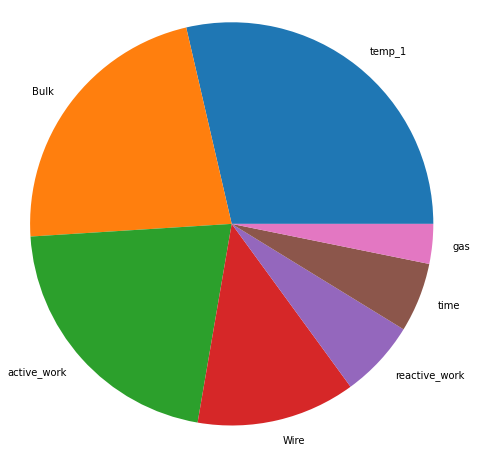

In [61]:
vals = importances['Importance']
labels = importances['Feature']
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(vals, labels=labels, pctdistance=1)
ax.axis("equal")

Все признаки достаточно важны. Удивительно, что сыпучие материалы имеют такую высокую важность для прогнозирования температуры.

## LightGBM

Обучим модель и посчитаем МАЕ

In [62]:
model_LGBM = lgb.LGBMRegressor()
model_LGBM.fit(features_train, target_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [63]:
mean_absolute_error(target_test, model_LGBM.predict(features_test))

5.729841545134207

Качество модели уже соответствует требованиям, но попробуем подобрать более оптимальные гиперпараметры.

In [64]:
parameters_grid = {
    'max_depth' : range(2, 30, 1),
    'num_leaves' : range(80,120,5),
    'learning_rate' : np.arange(0.2, 0.8, 0.02),
    'n_estimators' : range(80, 120, 5),
}

In [65]:
# %%time
# randomized_grid_cv = RandomizedSearchCV(model_LGBM, parameters_grid, n_iter=1000,
#                                                     scoring=make_scorer(mean_absolute_error,greater_is_better=False))

# randomized_grid_cv.fit(features_train, target_train)
# randomized_grid_cv.best_params_

Wall time: 7min 9s  
{'num_leaves': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.22}

In [66]:
model_LGBM = lgb.LGBMRegressor(num_leaves=90, n_estimators=100, max_depth=3, learning_rate=0.22)
model_LGBM.fit(features_train, target_train)
mae_lgbm = mean_absolute_error(target_test, model_LGBM.predict(features_test))
mae_lgbm

5.6252075322433335

Качество немного увеличилось. Полученная модель самая точная.

Также оценим важность признаков для модели.

In [67]:
importances = pd.DataFrame(index = features.columns,
                     columns=['Feature', 'Importance'])

importances.Importance = model_LGBM.feature_importances_

importances.Feature = importances.index

importances.Feature = importances.Feature.apply(feature_group)

importances = importances.groupby(by=['Feature']).sum().sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances

,Feature,Importance
0,Bulk,147
1,temp_1,99
2,active_work,78
3,time,77
4,Wire,76
5,gas,37
6,reactive_work,31


Отобразим на круговой диаграмме

(-1.1118104329227367,
 1.1005624015677493,
 -1.1100405749809783,
 1.1108004825420426)

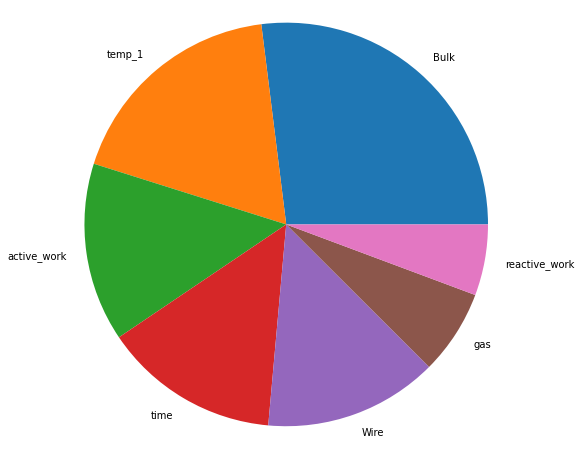

In [68]:
vals = importances['Importance']
labels = importances['Feature']
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(vals, labels=labels, pctdistance=1)
ax.axis("equal")

В этот раз важность признаков распределена более равномерно. Данные по сыпучим материалам очень важны. 

Соберем полученные МАЕ в таблицу

In [69]:
result = pd.DataFrame([['Linear', mae_linear], ['RandomForest', mae_rfr], ['LightGBM', mae_lgbm]],
                     columns=['Model', 'MAE'])

### Вывод:
Самое высокое качество показала LightGBM, самое низкое — модель случайного леса. При этом все модели удовлетворяют требования по метрике МАЕ (< 6).

# Общий вывод <a id='section6'></a>

#### Данные
При исследовании данных были обнаруженны аномалии в таблицах data_arc и data_temp. Более глубокое изучение показало, что аномалии вызваны ошибкой. Данные по партиям с аномалиями были удалены. Также было принято решение не использовать данные из таблиц data_bulk_time и data_wire_time, т.к. их использование протеворечило бы требованию заказчика (не использовать промежуточные данные по температуре). 

В ходе предобработки данных было обнаруженно, что некоторые партии записаны не по порядку. Это не помешало работе, т.к. каждая партия рассматриватся отдельно. В одной партии была нарушенна последовательность записей времени. Данные по это партии были удалены.

В некоторых партиях был всего один замер температуры, что не позволяло использовать данные по таким партиям.

Также было принято решение подготовить в качестве признаков произведенную работу (произведение мощности на время) по нагреву на всю партию. Это позволило не использовать промежуточные данные для обучения (требование заказчика). 

#### Модели
Было выбрано три модели: линейная регрессия, случайный лес и LightGBM. Для каждой модели подобраны оптимальные гиперпараметры. Все модели соответствуют требованию по МАЕ (< 6). Самой качественной оказалась LightGBM. Самое низкое качество показала модель случайного леса. Результаты каждой модели можно посмотреть в таблице ниже. 

Также для LightGBM и модели случайного леса была проведена оценка важности признаков. Все выбранные признаки показали высокую значимость.

In [70]:
result

,Model,MAE
0,Linear,5.771905
1,RandomForest,5.874733
2,LightGBM,5.625208
